# Binary Performance Evaluator – Demo Completo

Neste exemplo vamos treinar um classificador simples e explorar várias funcionalidades do `BinaryPerformanceEvaluator`. Usaremos dados sintéticos.

In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from riskpilot.evaluation import BinaryPerformanceEvaluator
from riskpilot.synthetic import SyntheticVintageGenerator

from sklearn.utils.class_weight import compute_sample_weight

In [15]:
# --------------------------------------------------
# 1. CONFIGURAÇÕES
# --------------------------------------------------
FILE_PATH = "../../datasets/lending_club/accepted_2007_to_2018Q4.csv"
NROWS     = 1_000
TARGET_RAW = "loan_status"          # coluna original
TARGET     = "target"               # nome final binário

# --------------------------------------------------
# 2. LEITURA E CONVERSÃO DE TIPOS MISTOS
# --------------------------------------------------
def read_and_clean_csv_mixed_types(path, nrows=None, verbose=True):
    df = pd.read_csv(path, low_memory=False, nrows=nrows)

    # identificar colunas com tipos mistos
    for col in df.columns:
        types = df[col].dropna().map(type).value_counts()
        if len(types) > 1 and verbose:
            print(f"[!] '{col}' com múltiplos tipos: {dict(types)}")

        # tentativa de conversão automática p/ numérico
        if len(types) > 1:
            try:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            except Exception:
                df[col] = df[col].astype(str)

    return df

df = read_and_clean_csv_mixed_types(FILE_PATH, nrows=NROWS)

# drop de colunas não usadas (caso existam)
df.drop(columns=[c for c in ["member_id"] if c in df.columns], inplace=True)

# --------------------------------------------------
# 3. TARGET BINÁRIO
# --------------------------------------------------
bad_status = ["Charged Off", "Default", "Late (31-120 days)"]
df[TARGET] = df[TARGET_RAW].isin(bad_status).astype(int)

# --------------------------------------------------
# 4. DATA E ID
# --------------------------------------------------
#df["date"] = pd.to_datetime(df["issue_d"], format="%b-%Y", errors="coerce")

df["date"] = pd.to_datetime('202201', format="%Y%M", errors="coerce")

df.drop(columns=["issue_d", TARGET_RAW], inplace=True)

df.reset_index(drop=False, inplace=True)   # index ➜ nova coluna

# --------------------------------------------------
# 5. FEATURES NUMÉRICAS + IMPUTAÇÃO
# --------------------------------------------------
numeric_cols = df.select_dtypes(include=[np.number]).columns.drop(["id", TARGET])
na_threshold = 0.30
valid_cols = numeric_cols[df[numeric_cols].isna().mean() < na_threshold].tolist()
valid_cols.remove('index')

df[valid_cols] = df[valid_cols].fillna(df[valid_cols].median())

# --------------------------------------------------
# 6. DATAFRAME FINAL
# --------------------------------------------------

FEATURES = [
    "funded_amnt_inv",
    "annual_inc",
    "dti",
    "fico_range_high",
    "out_prncp_inv",
    "total_rec_prncp",
    "last_pymnt_amnt",
    "last_fico_range_low",
    "acc_open_past_24mths",
    "avg_cur_bal",
    "bc_open_to_buy",
    "mo_sin_old_rev_tl_op",
    "mo_sin_rcnt_rev_tl_op",
    "mo_sin_rcnt_tl",
    "mort_acc",
    "mths_since_recent_bc",
    "mths_since_recent_inq",
    "num_tl_op_past_12m",
    "percent_bc_gt_75",
    "total_bc_limit",
    #"sub_grade"
]

ID_COLS = ['id']

IGNORE_COLS = ['member_id']

DATE_COLS = ['date']

# --------------------------------------------------
# Preparar dataset base
# --------------------------------------------------
df_model = df[ID_COLS+DATE_COLS+[TARGET] + FEATURES].dropna().copy()

In [16]:
ID_COLS

['id']

In [17]:
import numpy as np
from riskpilot.synthetic import SyntheticVintageGenerator

gen = SyntheticVintageGenerator(
    id_cols=ID_COLS,
    date_cols=DATE_COLS
).fit(df_model)

In [18]:
synthetic = gen.generate(
    n_periods=36,
    freq='ME',
    scenario='stress')
synthetic.head()

,id,date,target,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,...,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit
0,b9e41a477f684532a598a9cd6e2f59f0,2025-06-30,0,12000.0,82000.000000,12.670064,709.0,0.000000,6264.049981,984.719948,...,18421.268648,153.000000,43.025843,7.000000,5,71.063516,5.309105,4,42.9,41000.000000
1,c81d6525e6db411993ad3a8b15e6d099,2025-06-30,0,6000.0,31984.049803,13.912898,679.0,9580.147387,1777.011451,292.422176,...,278.252063,130.000000,24.000000,13.000000,0,123.205994,7.000000,1,100.0,3142.929444
2,001b8217591247969c69ebbde3f00014,2025-06-30,0,15000.0,135000.000000,22.906248,729.0,0.000000,7000.000000,3805.423957,...,10472.162342,257.000000,32.079301,36.000799,4,68.030138,1.000000,0,66.7,99517.354370
3,8f6f76f9df974112bb0d93c9521be72c,2025-06-30,0,12000.0,75000.000000,20.348964,754.0,0.000000,16000.000000,7173.956284,...,4151.820450,180.000000,6.000000,9.000000,2,11.000000,15.000000,2,100.0,23440.535188
4,768928d7b33e4cdcaaf75b2c1e238908,2025-06-30,0,18000.0,84000.000000,8.339263,744.0,0.000000,11512.624933,1513.866069,...,1313.543575,169.609776,1.000000,3.000000,3,12.000000,13.000000,2,100.0,21500.000000


In [19]:
# --------------------------------------------------
# 2. Split treino / teste
# --------------------------------------------------
train_idx, test_idx = train_test_split(
    df_model.index,
    test_size=0.30,
    stratify=df_model[TARGET],
    random_state=42,
)

# Criar df_train e df_test primeiro
df_train = df_model.loc[train_idx].copy()
df_test  = df_model.loc[test_idx].copy()

# Depois extrair X e y a partir dos DataFrames
X_train, y_train = df_train[FEATURES], df_train[TARGET]
X_test , y_test  = df_test[FEATURES] , df_test[TARGET]

In [20]:
# --------------------------------------------------
# Garantir cópias independentes dos conjuntos de treino e teste
# --------------------------------------------------
X_train = df_train[FEATURES].copy()
X_test = df_test[FEATURES].copy()

# --------------------------------------------------
# Converter colunas categóricas (tipo object) para 'category' em X e df
# --------------------------------------------------
def convert_object_to_category(df):
    obj_cols = df.select_dtypes(include='object').columns
    df[obj_cols] = df[obj_cols].astype('category')
    return df

# Aplicar nos conjuntos usados no modelo
X_train = convert_object_to_category(X_train)
X_test = convert_object_to_category(X_test)

# Garantir que df_train e df_test também estejam com tipos consistentes
df_train = convert_object_to_category(df_train)
df_test = convert_object_to_category(df_test)

# --------------------------------------------------
# Verificações finais
# --------------------------------------------------
print("Colunas 'object' restantes em X_train:", X_train.dtypes[X_train.dtypes == 'object'])
print("Colunas 'object' restantes em df_test:", df_test.dtypes[df_test.dtypes == 'object'])


Colunas 'object' restantes em X_train: Series([], dtype: object)
Colunas 'object' restantes em df_test: Series([], dtype: object)


In [21]:
num_cols = df_train.select_dtypes(include=[float, int]).columns.tolist()

for col in ['index', 'id', TARGET]:
    try:
        num_cols.remove(col)
    except:
        pass   

In [22]:
# Aplicar o DynamicScaler no treino
from riskpilot.utils.scaler import DynamicScaler
scaler = DynamicScaler(
    strategy="auto",
    shapiro_p_val = 0.01, # se aumentar fica mais restritiva a escolha de StandardScaler()
    #serialize=True,
    #save_path="scalers.pkl", # arquivo com informações de escalonamento salvas 
    random_state=42,
    ignore_cols=ID_COLS+IGNORE_COLS+DATE_COLS+[TARGET]
)

scaler.fit(df_train)

# Relatório das decisões
print("\nResumo das decisões por feature:")
display(scaler.report_as_df())

INFO: Ignoring columns (no scaling): ['target', 'id']



Resumo das decisões por feature:


c:\Users\JM\AppData\Local\anaconda3\envs\ENV_STONE\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (630). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\JM\AppData\Local\anaconda3\envs\ENV_STONE\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (630). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\JM\AppData\Local\anaconda3\envs\ENV_STONE\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (630). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\JM\AppData\Local\anaconda3\envs\ENV_STONE\lib\site-packages\sklearn\preprocessing\_data.py:2785: UserWarning: n_quantiles (1000) is greater than the total number of samples (630). n_quantiles is set to n_samples.
  warnings.warn(
c:\Users\JM\AppData\Local\anaconda3\envs\ENV

,chosen_scaler,validation_stats,ignored,candidates_tried,reason
funded_amnt_inv,None,"{'post_std': nan, 'post_iqr': nan, 'post_n_uni...",[],"[PowerTransformer, QuantileTransformer, Robust...",all_rejected
annual_inc,PowerTransformer,"{'post_std': 1.0000000000000002, 'post_iqr': 1...",[],[PowerTransformer],NaN
dti,None,"{'post_std': nan, 'post_iqr': nan, 'post_n_uni...",[],"[PowerTransformer, QuantileTransformer, Robust...",all_rejected
fico_range_high,None,"{'post_std': nan, 'post_iqr': nan, 'post_n_uni...",[],"[PowerTransformer, QuantileTransformer, Robust...",all_rejected
out_prncp_inv,None,"{'post_std': nan, 'post_iqr': nan, 'post_n_uni...",[],"[PowerTransformer, QuantileTransformer, Robust...",all_rejected
total_rec_prncp,PowerTransformer,"{'post_std': 1.0, 'post_iqr': 1.48435930287225...",[],[PowerTransformer],NaN
last_pymnt_amnt,PowerTransformer,"{'post_std': 0.9999999999999998, 'post_iqr': 1...",[],[PowerTransformer],NaN
last_fico_range_low,PowerTransformer,"{'post_std': 1.0, 'post_iqr': 1.04340299282014...",[],[PowerTransformer],NaN
acc_open_past_24mths,PowerTransformer,"{'post_std': 1.0, 'post_iqr': 1.68934796129987...",[],[PowerTransformer],NaN
avg_cur_bal,PowerTransformer,"{'post_std': 1.0, 'post_iqr': 1.50197816963828...",[],[PowerTransformer],NaN


In [23]:
scaler.report_as_df()['candidates_tried']

funded_amnt_inv          [PowerTransformer, QuantileTransformer, Robust...
annual_inc                                              [PowerTransformer]
dti                      [PowerTransformer, QuantileTransformer, Robust...
fico_range_high          [PowerTransformer, QuantileTransformer, Robust...
out_prncp_inv            [PowerTransformer, QuantileTransformer, Robust...
total_rec_prncp                                         [PowerTransformer]
last_pymnt_amnt                                         [PowerTransformer]
last_fico_range_low                                     [PowerTransformer]
acc_open_past_24mths                                    [PowerTransformer]
avg_cur_bal                                             [PowerTransformer]
bc_open_to_buy                                          [PowerTransformer]
mo_sin_old_rev_tl_op               [PowerTransformer, QuantileTransformer]
mo_sin_rcnt_rev_tl_op                                   [PowerTransformer]
mo_sin_rcnt_tl           

In [24]:
display(X_train.head())

# 5. Transformar o conjunto de treino
df_train_scaled = scaler.transform(df_train, return_df=True)
X_train_scaled = scaler.transform(X_train, return_df=True)

print("\nExemplo de dados escalados (treino):")
display(X_train_scaled.head())

,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,last_fico_range_low,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit
967,12000.0,50000.0,7.54,774.0,0.0,12000.00,361.28,805.0,2.0,1288.0,50612.0,266.0,24.0,24.0,0.0,24.0,5.0,0.0,0.0,61700.0
993,14000.0,132700.0,25.38,664.0,0.0,14000.00,93.38,705.0,10.0,9813.0,94.0,124.0,5.0,1.0,5.0,19.0,1.0,3.0,100.0,1300.0
78,20200.0,60000.0,34.84,724.0,0.0,4258.61,518.35,560.0,6.0,4322.0,9516.0,74.0,7.0,7.0,0.0,16.0,9.0,4.0,25.0,17800.0
305,12700.0,32760.0,34.32,679.0,0.0,12700.00,458.68,640.0,19.0,1300.0,12822.0,129.0,1.0,1.0,0.0,2.0,1.0,11.0,33.3,22000.0
577,9600.0,110000.0,13.83,669.0,0.0,9600.00,5548.36,720.0,4.0,4003.0,2456.0,335.0,4.0,4.0,1.0,4.0,5.0,2.0,33.3,10000.0


INFO: Untouched columns preserved: ['target', 'id', 'date']



Exemplo de dados escalados (treino):


,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,last_fico_range_low,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit
967,12000.0,-0.722739,7.54,774.0,0.0,0.087341,-0.741696,1.540560,-0.924677,-1.539897,1.758913,0.856017,1.148261,1.810554,-1.217353,0.613780,0.038210,-1.709949,-1.452773,1.464760
993,14000.0,1.309040,25.38,664.0,0.0,0.313503,-1.331462,0.247349,1.392940,0.001404,-1.757893,-0.693749,-0.284326,-1.317889,1.347085,0.401500,-1.146720,0.550157,1.243026,-1.852264
78,20200.0,-0.348660,34.84,724.0,0.0,-1.094868,-0.569343,-1.284193,0.473660,-0.682840,0.319734,-1.480388,0.008623,0.451281,-1.217353,0.246818,0.710408,0.953208,-0.091682,-0.064110
305,12700.0,-1.580790,34.32,679.0,0.0,0.168759,-0.628469,-0.488904,2.836107,-1.533954,0.539712,-0.644404,-1.422810,-1.317889,-1.217353,-1.408076,-1.146720,2.651423,0.125905,0.155909
577,9600.0,0.912908,13.83,669.0,0.0,-0.214245,0.739388,0.428860,-0.128114,-0.742277,-0.517849,1.305559,-0.471088,-0.133928,-0.154114,-0.919974,0.038210,0.047358,0.125905,-0.593499


In [25]:
display(X_test.head())

# 5. Transformar o conjunto de treino
df_test_scaled = scaler.transform(df_test, return_df=True)
X_test_scaled = scaler.transform(X_test, return_df=True)

print("\nExemplo de dados escalados (treino):")
display(X_test_scaled.head())

,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,last_fico_range_low,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit
14,28000.0,92000.0,21.60,724.0,0.0,28000.0,17093.51,760.0,1.0,13819.0,16623.0,379.0,19.0,19.0,2.0,19.0,5.0,0.0,22.2,41500.0
272,7200.0,60000.0,20.68,729.0,0.0,7200.0,3196.17,725.0,4.0,13026.0,2273.0,159.0,16.0,8.0,1.0,55.0,8.0,1.0,0.0,7000.0
928,28000.0,82000.0,12.67,704.0,0.0,28000.0,857.84,800.0,6.0,25361.0,6508.0,187.0,9.0,9.0,5.0,9.0,8.0,2.0,66.7,39050.0
723,10000.0,100000.0,16.18,679.0,0.0,10000.0,9437.82,555.0,9.0,3273.0,5982.0,349.0,14.0,2.0,0.0,14.0,14.0,3.0,80.0,15100.0
244,13875.0,32500.0,23.53,714.0,0.0,13875.0,11101.71,705.0,3.0,17421.0,2076.0,177.0,1.0,1.0,1.0,15.0,15.0,1.0,75.0,12500.0


INFO: Untouched columns preserved: ['target', 'id', 'date']



Exemplo de dados escalados (treino):


,funded_amnt_inv,annual_inc,dti,fico_range_high,out_prncp_inv,total_rec_prncp,last_pymnt_amnt,last_fico_range_low,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_tl_op_past_12m,percent_bc_gt_75,total_bc_limit
14,28000.0,0.538105,21.60,724.0,0.0,1.541292,1.482690,0.934344,-1.469213,0.315198,0.743219,1.725673,0.927649,1.550825,0.424968,0.401500,0.038210,-1.709949,-0.174479,0.910440
272,7200.0,-0.348660,20.68,729.0,0.0,-0.562154,0.405497,0.490336,-0.128114,0.259773,-0.558673,-0.213179,0.766190,0.595649,-0.154114,1.379999,0.564644,-0.630364,-1.452773,-0.875845
928,28000.0,0.298032,12.67,704.0,0.0,1.541292,-0.317624,1.471230,0.473660,0.916579,0.059355,0.142125,0.234392,0.724024,1.347085,-0.258661,0.564644,0.047358,0.772776,0.831365
723,10000.0,0.712695,16.18,679.0,0.0,-0.161243,1.079532,-1.329884,1.187695,-0.894863,0.004459,1.454085,0.641392,-0.786831,-1.217353,0.127648,1.308619,0.550157,0.974452,-0.225093
244,13875.0,-1.596835,23.53,714.0,0.0,0.299924,1.187291,0.247349,-0.492397,0.537646,-0.605602,0.008965,-1.422810,-1.317889,-0.154114,0.189101,1.409561,-0.630364,0.901166,-0.399981


INFO: Plotando histograma de funded_amnt_inv — scaler = Nenhum


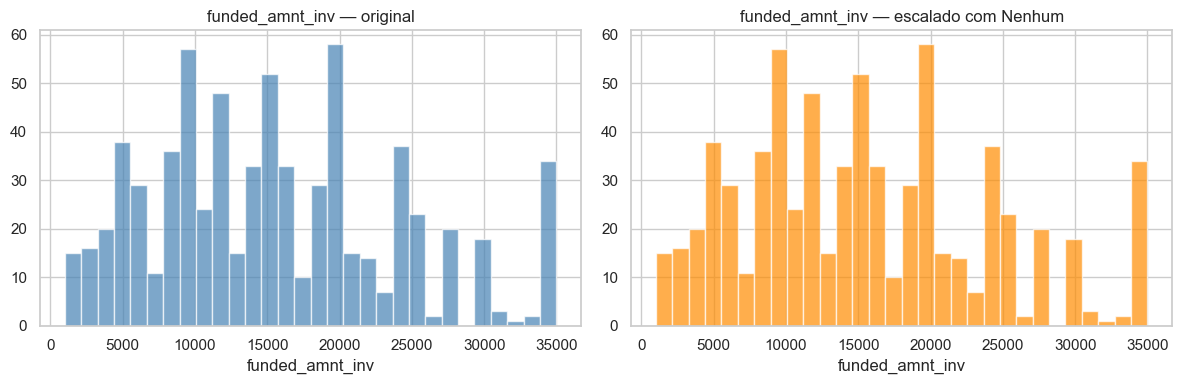

INFO: Plotando histograma de annual_inc — scaler = PowerTransformer


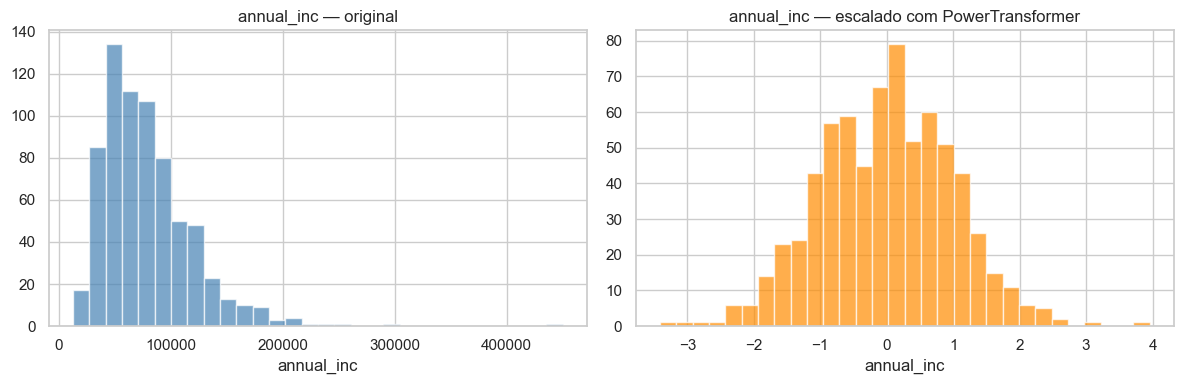

INFO: Plotando histograma de dti — scaler = Nenhum


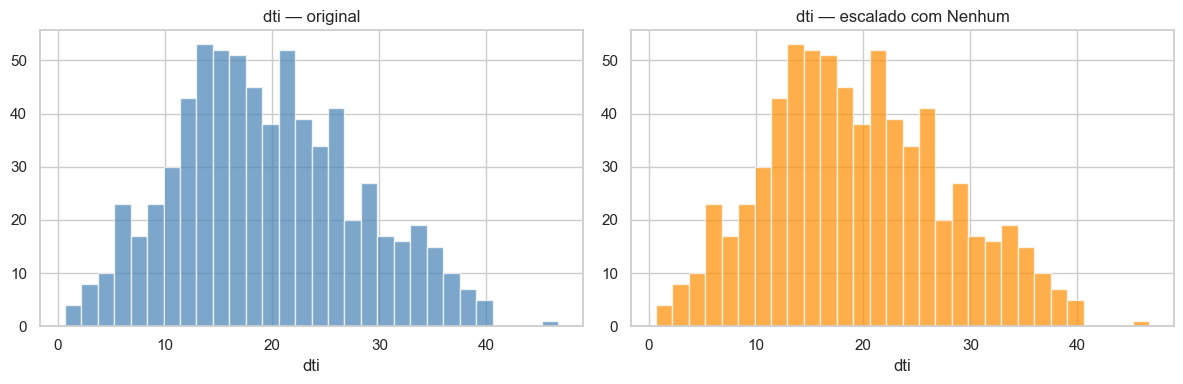

INFO: Plotando histograma de fico_range_high — scaler = Nenhum


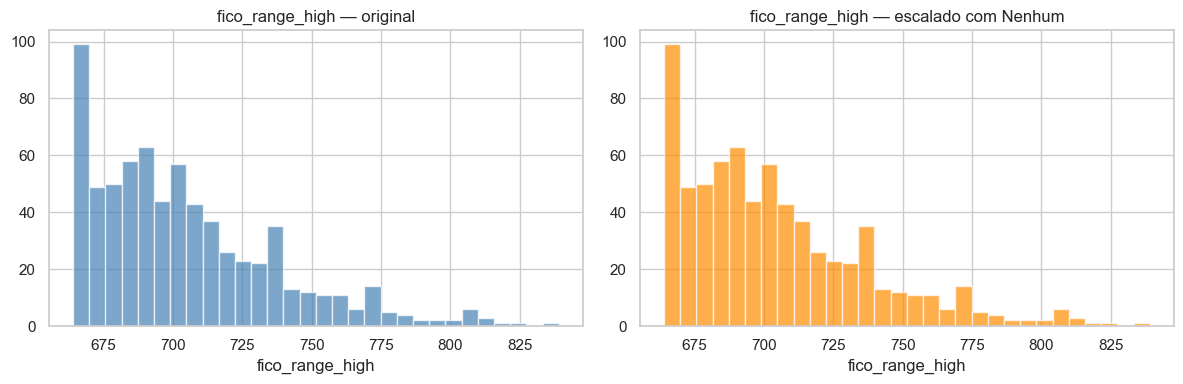

INFO: Plotando histograma de out_prncp_inv — scaler = Nenhum


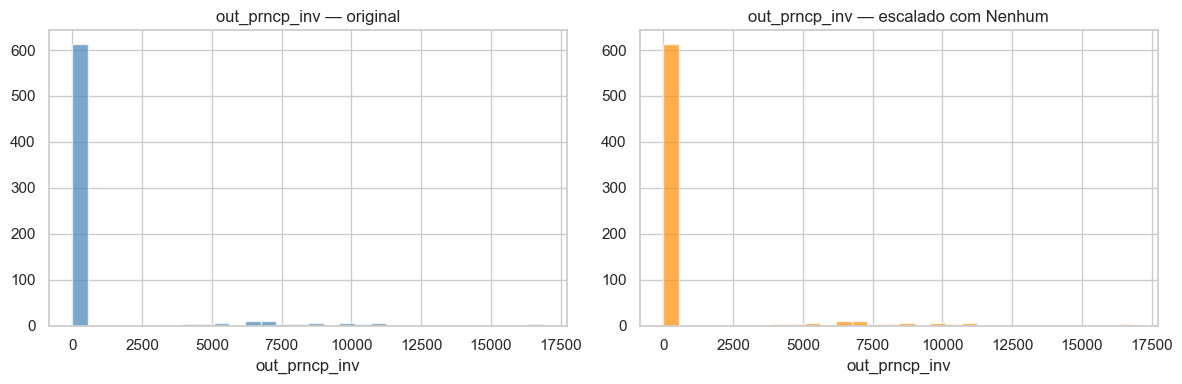

INFO: Plotando histograma de total_rec_prncp — scaler = PowerTransformer


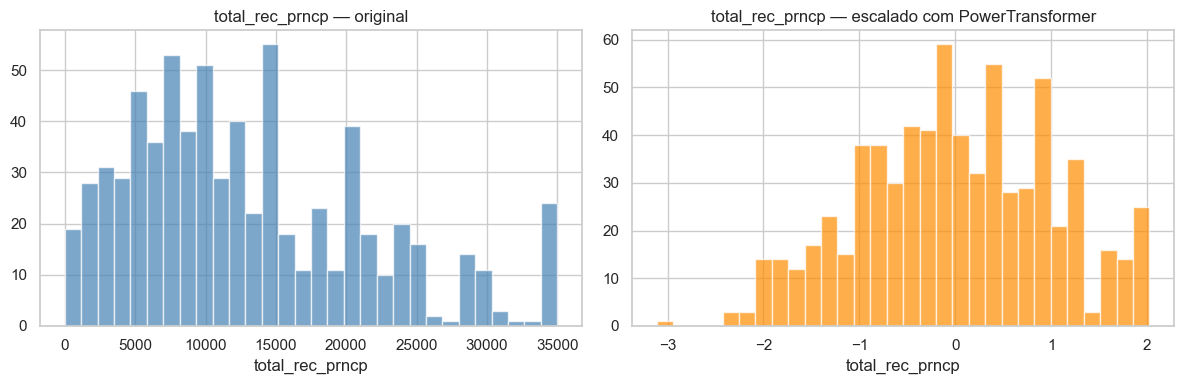

INFO: Plotando histograma de last_pymnt_amnt — scaler = PowerTransformer


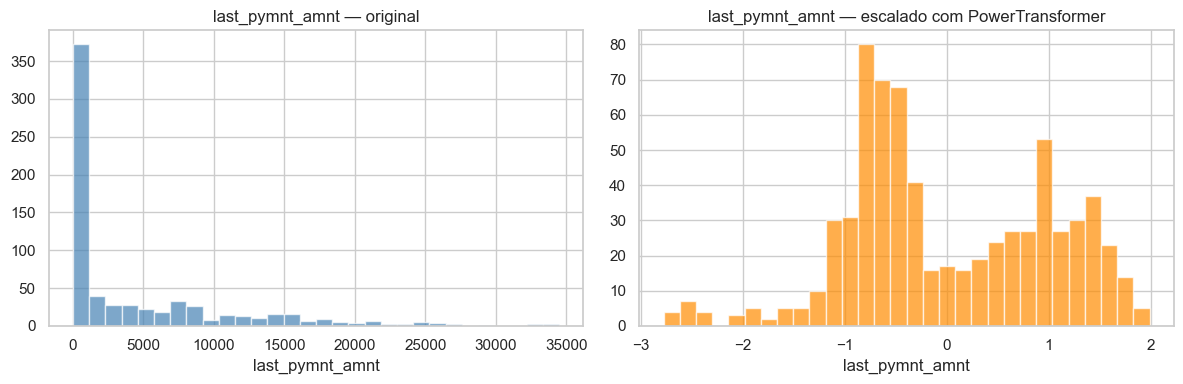

INFO: Plotando histograma de last_fico_range_low — scaler = PowerTransformer


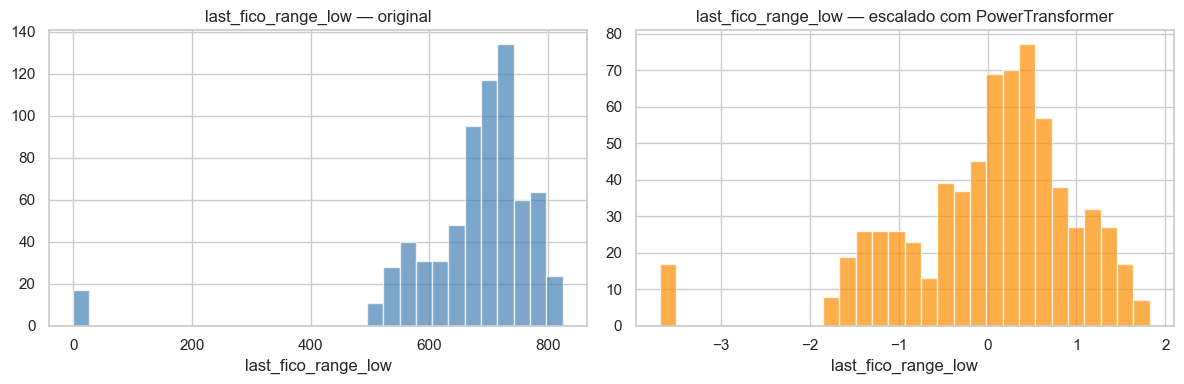

INFO: Plotando histograma de acc_open_past_24mths — scaler = PowerTransformer


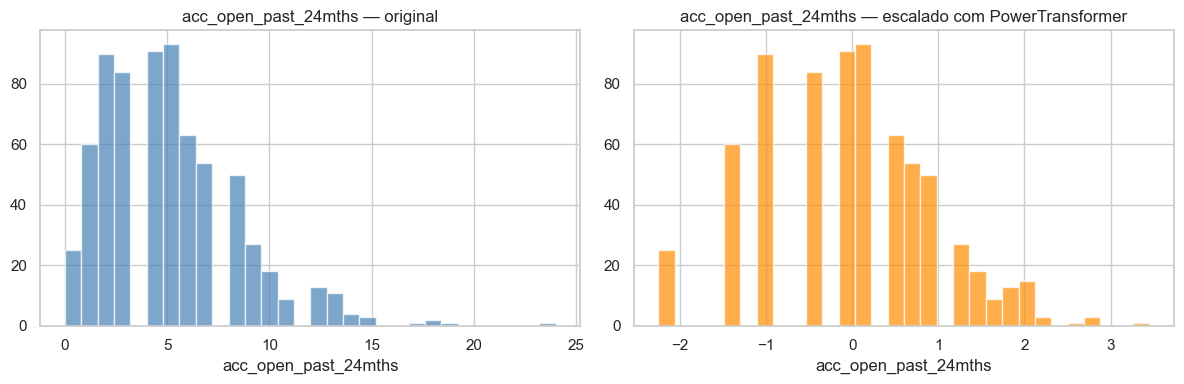

INFO: Plotando histograma de avg_cur_bal — scaler = PowerTransformer


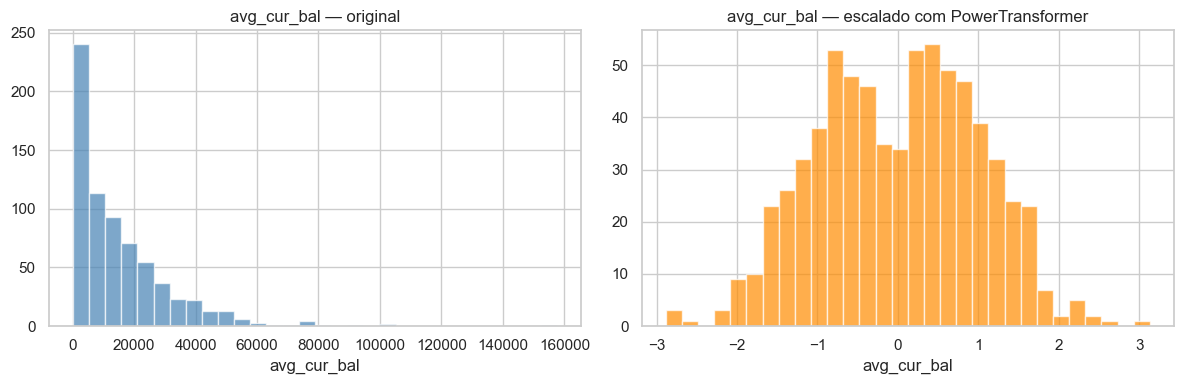

INFO: Plotando histograma de bc_open_to_buy — scaler = PowerTransformer


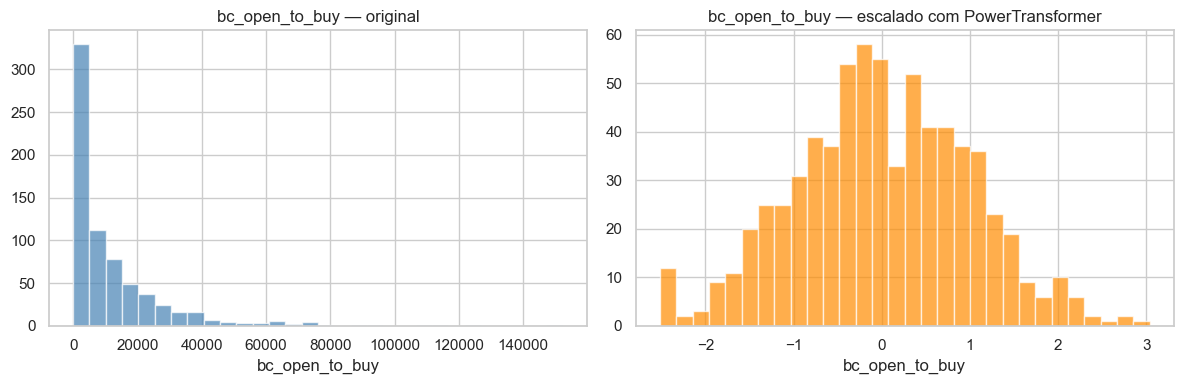

INFO: Plotando histograma de mo_sin_old_rev_tl_op — scaler = QuantileTransformer


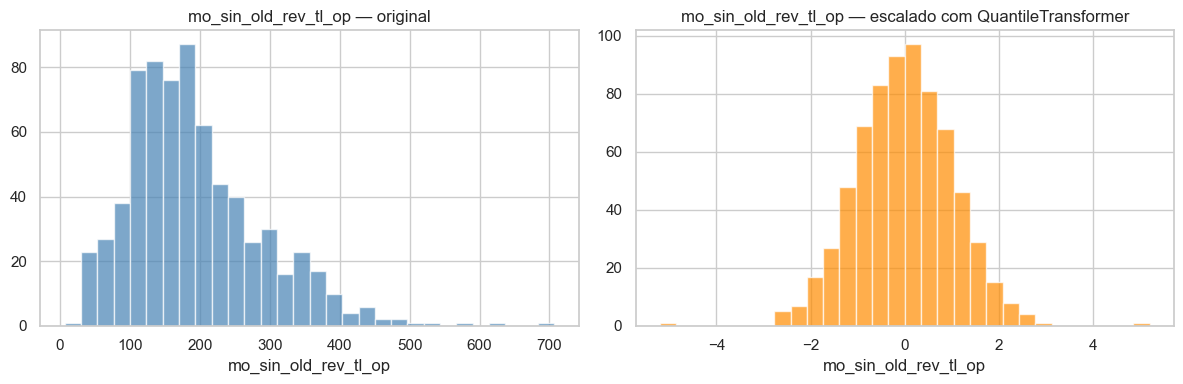

INFO: Plotando histograma de mo_sin_rcnt_rev_tl_op — scaler = PowerTransformer


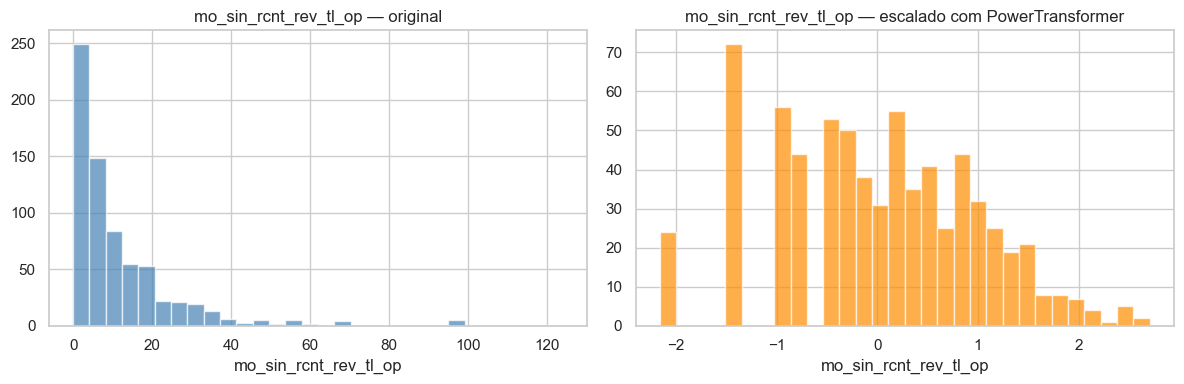

INFO: Plotando histograma de mo_sin_rcnt_tl — scaler = PowerTransformer


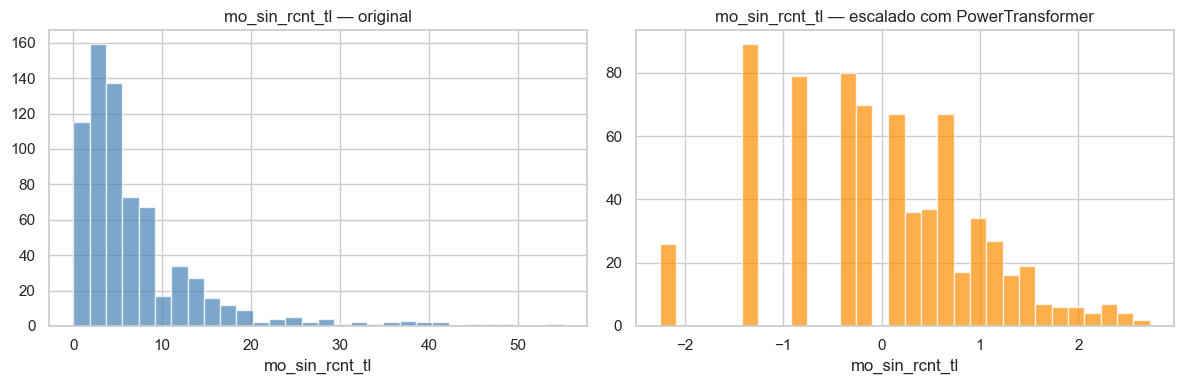

INFO: Plotando histograma de mort_acc — scaler = PowerTransformer


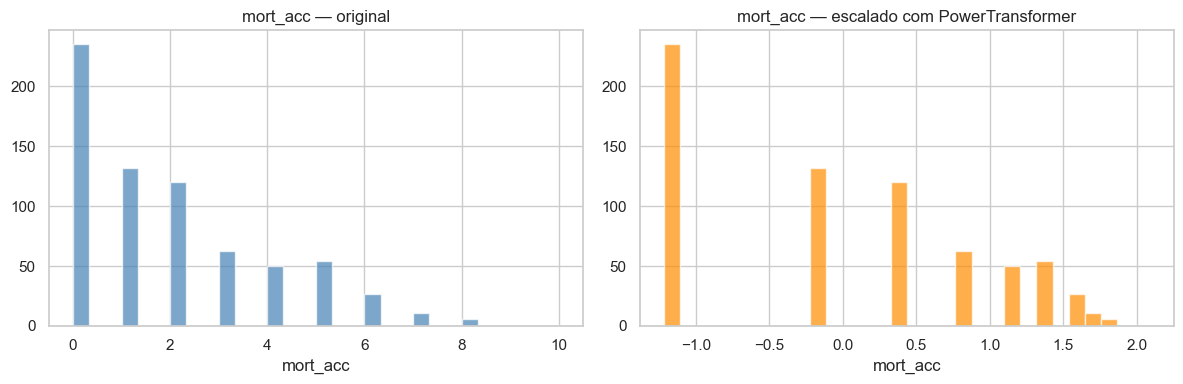

INFO: Plotando histograma de mths_since_recent_bc — scaler = PowerTransformer


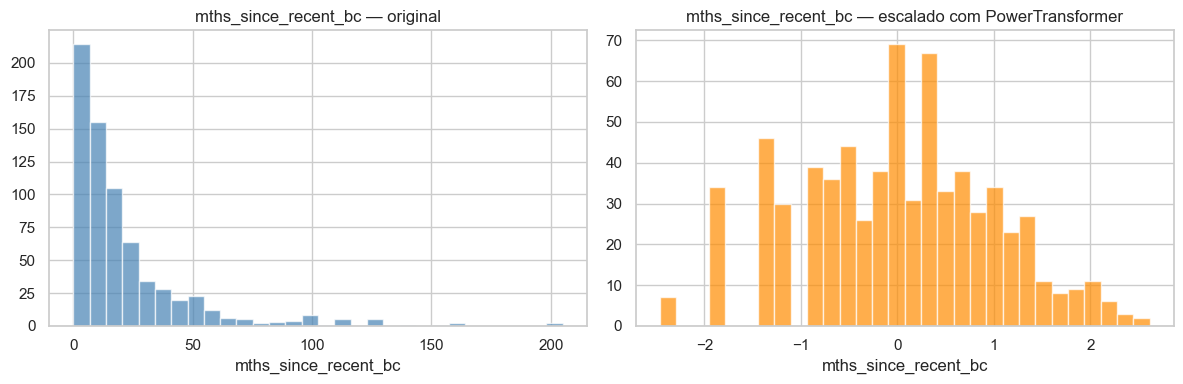

INFO: Plotando histograma de mths_since_recent_inq — scaler = PowerTransformer


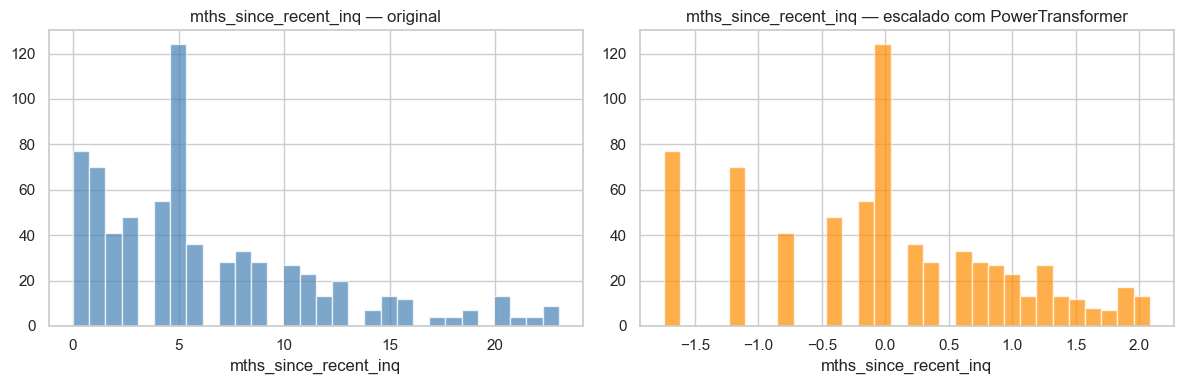

INFO: Plotando histograma de num_tl_op_past_12m — scaler = PowerTransformer


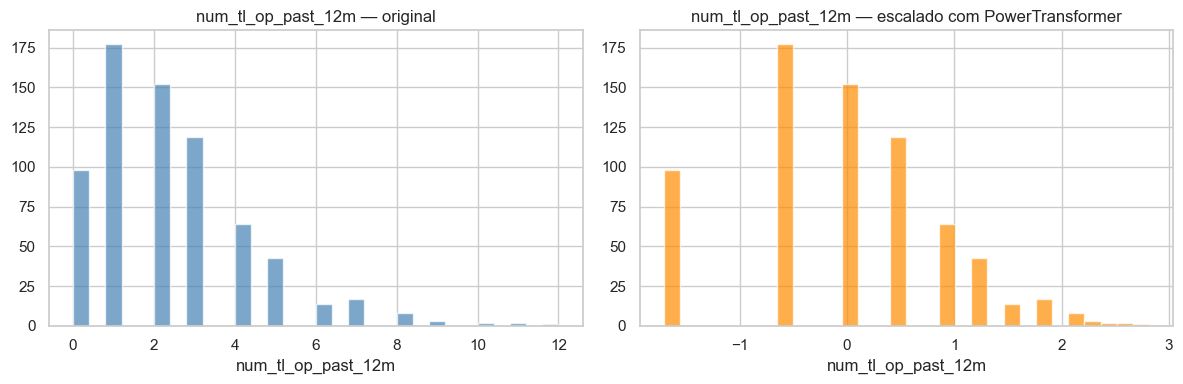

INFO: Plotando histograma de percent_bc_gt_75 — scaler = PowerTransformer


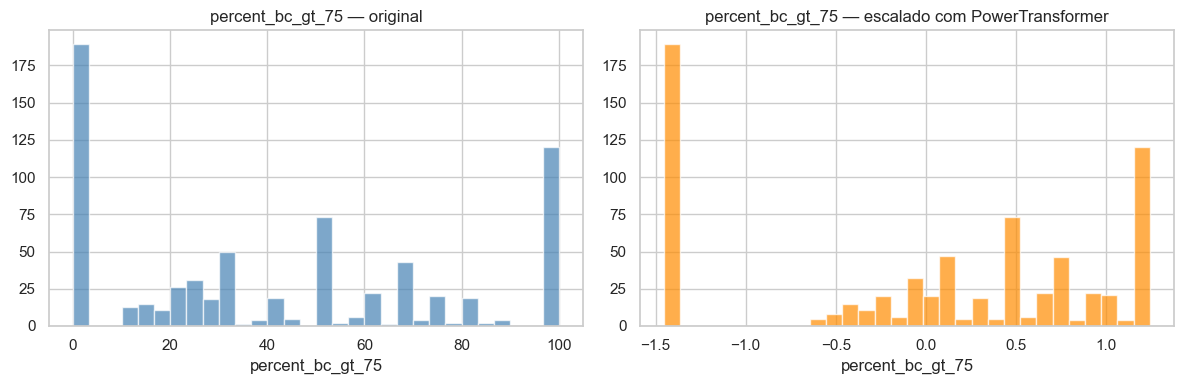

INFO: Plotando histograma de total_bc_limit — scaler = PowerTransformer


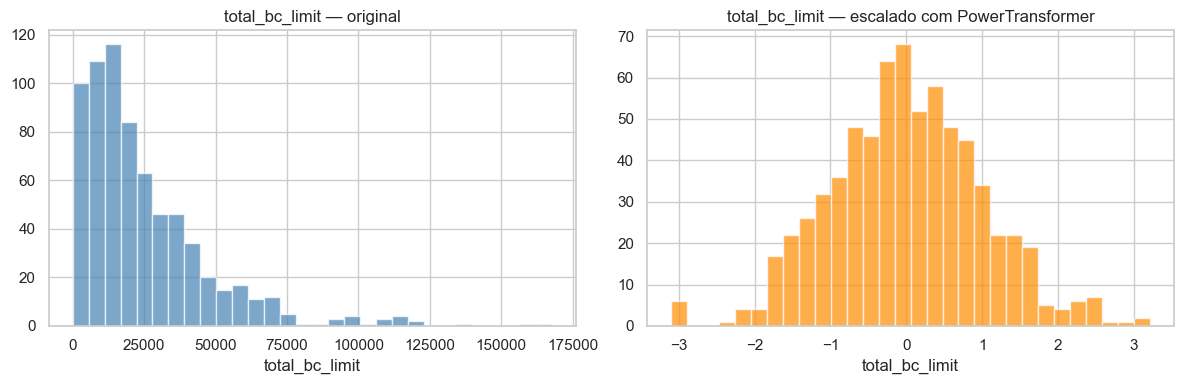

In [26]:
# Visualizar
scaler.plot_histograms(
    df_train,
    X_train_scaled,
    features=num_cols)

In [9]:
# encoder = WOEGuard(
#     categorical_cols=categorical_cols,
#     drop_original=True,       # mantém ou remove colunas originais
#     suffix='_woe',            # sufixo para as novas colunas
#     alpha=0.5,                # suavização Laplace
#     default_woe=0.0,          # WoE default para categorias novas
#     include_nan=True          # trata NaN como categoria separada
# )

In [10]:
# # 2. Ajustar e transformar
# df_transformed = encoder.fit_transform(
#     X=df[categorical_cols], # a lista de colunas não precisa ser igual à categorical_cols, mas somente as que forem instanciadas no WOEGuard que serão codificadas.
#     y=df[TARGET]
# )
# display(df_transformed)

In [64]:
sample_weights_train = compute_sample_weight(class_weight='balanced', y=y_train)

# # Modelo 1: Regressão Logística
# model1 = LogisticRegression(
#     max_iter=2000,
#     solver='lbfgs',
#     class_weight=None,      # Removido porque vamos usar sample_weight manualmente
#     C=1.0
# )
# model1.fit(X_train, y_train, sample_weight=sample_weights_train)


# Modelo 2: XGBoost


model2 = XGBClassifier(
    n_estimators=150,
    #class_weights='balanced',
    learning_rate=0.05,
    max_depth=5,
    subsample=0.85,
    colsample_bytree=0.80,
    #scale_pos_weight=1.0,
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1,
    #enable_categorical=True,
    #tree_method='hist'  # necessário com enable_categorical=True
)
model2.fit(
    X_train_scaled,
    y_train,
    sample_weight=sample_weights_train
    );

In [ ]:
# gambiarra rapida
#df_train = pd.concat([X_train_scaled, y_train], axis=1)
#df_test = pd.concat([X_test_scaled, y_train], axis=1)

In [65]:
evaluator = BinaryPerformanceEvaluator(
    model=model2,
    df_train=df_train,
    df_test=df_test,
    target_col='target',
    id_cols=['id'],
    date_col='date',
    homogeneous_group='auto'
    #group_col='group'
)

In [66]:
metrics = evaluator.compute_metrics()
metrics

,MCC,AUC_ROC,AUC_PR,Precision,Recall,Brier
Split,,,,,,
Train,0.0,0.596519,0.193577,0.15,1.0,0.841397
Test,0.0,0.601830,0.206996,0.15,1.0,0.841403


In [67]:
evaluator.plot_confusion(evaluator.df_test['target'], evaluator.df_test['y_pred_proba'], threshold='ks')

In [68]:
evaluator.plot_calibration()

In [69]:
evaluator.plot_event_rate()

(Figure({
     'data': [{'line': {'color': 'rgb(65,124,167)'},
               'mode': 'lines+markers',
               'name': '(-inf, inf)',
               'type': 'scatter',
               'x': array(['2015-12-01T00:00:00.000000000'], dtype='datetime64[ns]'),
               'y': {'bdata': 'MzMzMzMzwz8=', 'dtype': 'f8'}}],
     'layout': {'template': '...',
                'title': {'text': 'Event Rate by Group over Time'},
                'xaxis': {'title': {'text': 'date'}},
                'yaxis': {'title': {'text': 'Event rate'}}}
 }),
 Figure({
     'data': [{'marker': {'color': 'rgb(65,124,167)'},
               'name': '(-inf, inf)',
               'type': 'bar',
               'x': array(['2015-12-01T00:00:00.000000000'], dtype='datetime64[ns]'),
               'y': {'bdata': 'AAAAAAAA8D8=', 'dtype': 'f8'}}],
     'layout': {'barmode': 'stack',
                'template': '...',
                'title': {'text': 'Group Share over Time'},
                'xaxis': {'title': {'te

In [70]:
evaluator.plot_psi(reference_last_period=True)

In [ ]:
evaluator.plot_ks()

In [ ]:
evaluator.plot_group_radar()

In [ ]:
evaluator.plot_decile_ks()

### Teste de Stress

In [ ]:
gen = SyntheticVintageGenerator(id_cols=['id'], date_cols=['date']).fit(train)
evaluator.synthetic_gen = gen
stress = evaluator.run_stress_test()
stress['metrics']